In [ ]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

# Shape of tensors: SxCxWxH
# S = samples
# C = channels
# W = width
# H = height

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

KL-Divergence

https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians

$$
\(\mathbb{KL}\left( \mathcal{N}(\mu, \sigma) \parallel \mathcal{N}(0, 1) \right) = \sum_{x \in X} \left( \sigma^2 + \mu^2 - \log \sigma - \frac{1}{2} \right)\)
$$

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda()
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        # Flatten each batch element from 1x28x28 to 784
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu = self.linear2(x)
        out = self.linear3(x)
        sigma = torch.exp(out)

        """Let x represent the data value, mu represent
        the mean,sigma represent the standard deviation,
        and z represent the z-score. Since the z-score is the
        number of standard deviations above the
        mean, z = (x - mu)/sigma. Solving for the data
        value,x, gives the formula x = z*sigma + mu.
        In the below case, the variables are switched around
        a bit. Our 'z' value comes from self.N.sample()"""
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z


In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))

        # shape: SxCxWxH
        return z.reshape((-1, 1, 28, 28))

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

def train(autoencoder, data, epochs=5):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        print(f'epoch: {epoch}')
        for x, y in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder


In [4]:
mnist = torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True)

data = torch.utils.data.DataLoader(mnist, batch_size=15, shuffle=True)
latent_dims = 2
vae = VariationalAutoencoder(latent_dims).to(device)
autoencoder = train(vae, data, epochs=10)

epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9


In [5]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

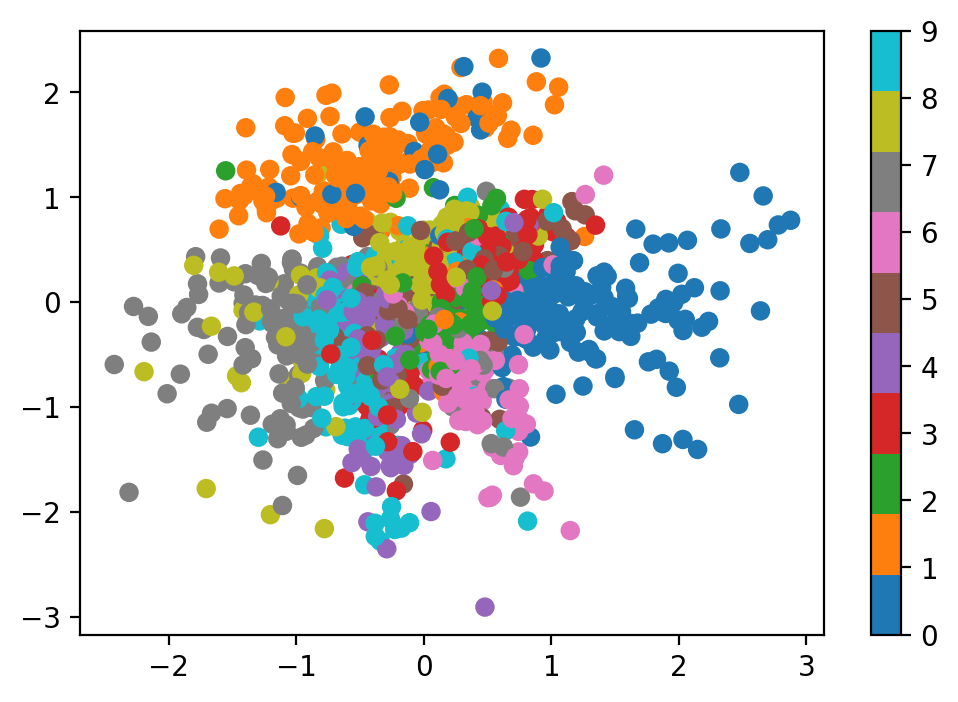

In [6]:
plot_latent(vae, data)

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19


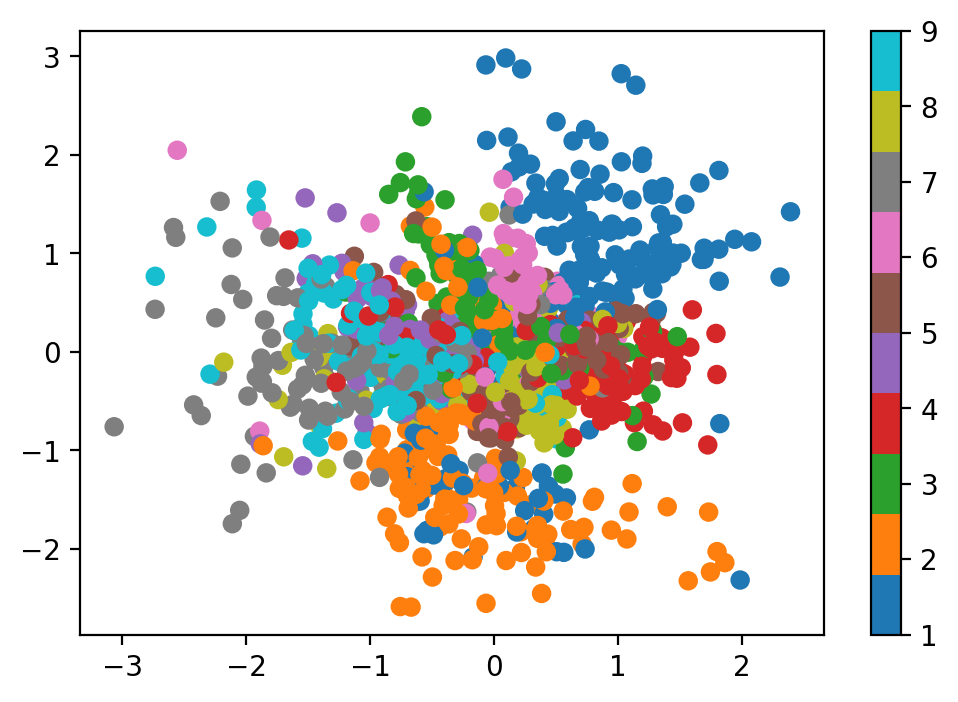

In [7]:
vae = VariationalAutoencoder(latent_dims).to(device)
autoencoder = train(vae, data, epochs=20)
plot_latent(vae, data)